In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from gymnasium import Env, spaces, register, make
import random
import pygame
import matplotlib.image as mpimg
from random import randint
%load_ext autoreload

In [3]:
%autoreload 2
from RME_file import RandomMazeEnvironment as RM_env
from RME_file import Possibilities as P
register(id = 'RME-mark0', entry_point=RM_env)

In [4]:
env = make('RME-mark0')
optimized_policy = np.array([1, 1, 1, 0, 0, 2, 0, 0, 0, 3, 0, 3])
theta = 10 ** -10
gamma = 0.99
totalStates = 12
real_state_array = [x for x in range(12) if x != 5]
real_state_array

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

# Subproblem 1

In [5]:
def generateTrajectory(env, policy, maxSteps, info, obs):
    
    episode = 0
    completed_episode = 0
    all_experience = [obs] 
    initial_state = 8
    total_reward = info['Reward']
    
    for i in range(maxSteps):
        
        state = info['Start State']
        action = policy[state]
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        
        
        experience = (np.array(observation))
        all_experience.append(experience)
        
        if terminated:
            observation, info = env.reset()
            return all_experience, total_reward
        
        if i == maxSteps - 1 and not terminated:
            truncated = True
            all_experience = []
            observation, info = env.reset()
            return all_experience, total_reward
    

In [8]:
np.random.seed(9569)
obs, info = env.reset()
all_exp, total_reward = generateTrajectory(env, optimized_policy, 100, info, obs)
exp= np.array(all_exp)
print(exp)
print(f'Trajectory: {exp[:, 0]}')
print(f'Total Reward: {total_reward}')#using optimized policy, we see that it terminates to 3

[[ 8.    2.    8.   -0.04]
 [ 8.    0.    4.   -0.04]
 [ 4.    0.    0.   -0.04]
 [ 0.    0.    0.   -0.04]
 [ 0.    1.    0.   -0.04]
 [ 0.    1.    0.   -0.04]
 [ 0.    1.    1.   -0.04]
 [ 1.    1.    2.   -0.04]
 [ 2.    1.    3.    1.  ]]
Trajectory: [8. 8. 4. 0. 0. 0. 0. 1. 2.]
Total Reward: 0.6799999999999999


# Subproblem 2

In [9]:
# Here decayType can be linear or exponential.
def decayAlpha(initialValue, finalValue, maxSteps, decayType):
    timestep_array = range(maxSteps)
    alpha_array = np.zeros(maxSteps)
    
    if (decayType == 'exponential'):
        theta = -(np.log(finalValue/initialValue))/(maxSteps -1)
        
        for step in timestep_array:
            alpha_array[step] = initialValue*(np.exp(-theta*step))
        
    if (decayType == 'linear'):
        theta = -(finalValue - initialValue)/(maxSteps - 1)
        
        for step in timestep_array:
            alpha_array[step] = initialValue - theta*step
    
    return alpha_array

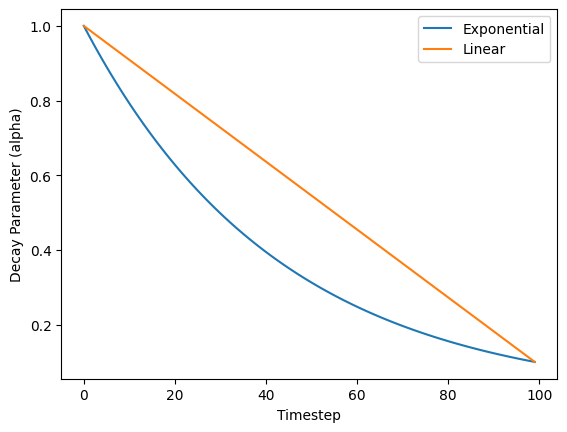

In [10]:
alpha_array = decayAlpha(1, 0.1, 100, 'exponential')
alpha_array2 = decayAlpha(1, 0.1, 100, 'linear')
plt.plot(range(100), alpha_array, label = 'Exponential')
plt.plot(range(100), alpha_array2, label = 'Linear')
plt.xlabel('Timestep')
plt.ylabel('Decay Parameter (alpha)')
plt.legend()
plt.show()

# Subproblem 3

In [11]:
def MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, firstVisit, chosen_NTstate):
    v = np.zeros(12)
    v_r = np.zeros((noEpisodes, 12))
    target_value = np.zeros(noEpisodes)
    visited = [False, False,False,False,False,False,False,False,False,False,False,False] 
    observation, info = env.reset()
    
    for e in range(noEpisodes):
        
        t, total_reward = generateTrajectory(env, policy, maxSteps, info, observation) 
        
        visited = [False, False,False,False,False,False,False,False,False,False,False,False] 
        
        for i, (s, a, s_next, r) in enumerate(t): 
            s = int(s)
            if visited[s] == True and firstVisit == True: #FVMC and EVMC settings, if firstVisit =  True => FVMC, otherwise EVMC
                continue
            else:
                visited[s] = True
                G = 0
                for j in range(i, len(t)):
                    G += (gamma**(j-i))*t[j][3]
                
                if s == chosen_NTstate:
                    target_value[e] += G
                    
                v[s] += alpha[e]*(G - v[s])
        
        v_r[e] = v.copy()
    observation, info = env.reset()
    return v, v_r, target_value


In [12]:
noEpisodes = 5
alpha = decayAlpha(0.5, 0.05, noEpisodes, 'exponential')
v, v_r, target_value = MonteCarloPrediction(env, optimized_policy, gamma, alpha, 200, noEpisodes, True, 3)
print('Monte Carlo Prediction:\n\n')
print(f"True Estimate of all states from 0 to 11 after {noEpisodes} episodes completion: \t{v}\n")
print('--------------------------------------------------------------------------------------------------------------\n')
print(f"Target Value of state 3 for {noEpisodes} episodes: \t {v}\n")
print('--------------------------------------------------------------------------------------------------------------\n')
for i in range(noEpisodes):
    print(f"Episodic estimate of all states from 0 to 11 at {i+1} episode: \t {v_r[i]}\n")

Monte Carlo Prediction:


True Estimate of all states from 0 to 11 after 5 episodes completion: 	[0.52303277 0.67450386 0.71113934 0.         0.48426194 0.
 0.13463318 0.         0.4256143  0.         0.         0.        ]

--------------------------------------------------------------------------------------------------------------

Target Value of state 3 for 5 episodes: 	 [0.52303277 0.67450386 0.71113934 0.         0.48426194 0.
 0.13463318 0.         0.4256143  0.         0.         0.        ]

--------------------------------------------------------------------------------------------------------------

Episodic estimate of all states from 0 to 11 at 1 episode: 	 [0.33016337 0.475      0.5        0.         0.30686174 0.
 0.         0.         0.26095519 0.         0.         0.        ]

Episodic estimate of all states from 0 to 11 at 2 episode: 	 [0.47674653 0.60855606 0.64058533 0.         0.44635565 0.
 0.         0.         0.39985211 0.         0.         0.        ]

Epi

# Subproblem 4

In [15]:
def TemporalDifferencePrediction(env, policy, gamma, alpha, noEpisodes, chosenNTstate):
    v = np.zeros(12)
    v_r = np.zeros((noEpisodes, 12))
    target_value = np.zeros(noEpisodes)
    
    for e in range(noEpisodes):
        observation, info = env.reset()
        while info['termination_status'] == False:
            
            state = info['Start State']
            action = policy[state]
            observation, reward, terminated, truncated, info = env.step(action)
            td_target = reward
            s_next = info['Next State']
            s = info['Start State']
            
            if info['termination_status'] == False:
                td_target += gamma*v[s_next]
            
            if s == chosenNTstate:
                target_value[e] += td_target
            
            
            td_error =td_target - v[s]
            
            v[s] += alpha[e]*td_error
            s = s_next
        
        v_r[e] = v
    observation, info = env.reset()
    return v, v_r, target_value

In [17]:
alpha = decayAlpha(0.5, 0.05, noEpisodes, 'exponential')
v, v_r, target_value = TemporalDifferencePrediction(env, optimized_policy, gamma, alpha, noEpisodes, 3)
print('Temporal Difference Prediction:\n\n')
print(f"True Estimate of all states from 0 to 6 after {noEpisodes} episodes completion: {v}\n")
print('--------------------------------------------------------------------------------------------------------------\n')
print(f"Target Value of state 3 for {noEpisodes} episodes: {v}\n")
print('--------------------------------------------------------------------------------------------------------------\n')
for i in range(noEpisodes):
    print(f"Episodic estimate of all states from 0 to 12 at {i+1} episode: { v_r[i]}\n")

Temporal Difference Prediction:


True Estimate of all states from 0 to 6 after 5 episodes completion: [-0.0066949   0.23544887  0.73810203  0.         -0.04193393  0.
  0.          0.         -0.04697992 -0.01674949  0.          0.        ]

--------------------------------------------------------------------------------------------------------------

Target Value of state 3 for 5 episodes: [-0.0066949   0.23544887  0.73810203  0.         -0.04193393  0.
  0.          0.         -0.04697992 -0.01674949  0.          0.        ]

--------------------------------------------------------------------------------------------------------------

Episodic estimate of all states from 0 to 12 at 1 episode: [-0.02 -0.02  0.5   0.   -0.02  0.    0.    0.   -0.02  0.    0.    0.  ]

Episodic estimate of all states from 0 to 12 at 2 episode: [-0.03923472  0.11355606  0.64058533  0.         -0.03119059  0.
  0.          0.         -0.03119059  0.          0.          0.        ]

Episodic estimate of

# Subproblem 8, 14, 20

In [30]:
alpha1 = decayAlpha(0.5, 0.01, 250, 'exponential')
last_alpha_value = alpha1[-1]
total_episode = range(500)
indices = [0, 1, 2, 4, 6, 8,9,10,11]

chosen_nonTerminal_state = 3
alpha = np.concatenate((alpha1, np.full(250, last_alpha_value)))

In [40]:
def plot_results(v, v_r, target_value, total_episode, chosen_nonTerminal_state, titles):

    # Plot for FVMC with different titles
    for idx, title in enumerate(titles):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.set_title(title)
        ax.set_xlabel('Episode')
        
        if idx == len(titles) - 1:  # Plotting the target value
            ax.plot(total_episode, target_value)
            ax.plot(total_episode, [v[chosen_nonTerminal_state]] * 500, label=f'v_state{chosen_nonTerminal_state}')
            ax.text(400, v[chosen_nonTerminal_state], f'v_state{chosen_nonTerminal_state}', horizontalalignment='left', verticalalignment='center')
            ax.set_ylabel('Target Value (Gt)')
        else:  # Plotting v and v_r
            for i in indices:
                ax.plot(total_episode, v_r[:, i], label=f'v_r_state{i}')
                ax.plot(total_episode, [v[i]] * 500, label=f'v_state{i}')
                ax.text(400, v[i], f'v_state{i}', horizontalalignment='left', verticalalignment='center')
            ax.set_ylabel('State-Value Estimate')

            if idx == 1:  # Set x-scale to log for the second figure
                ax.set_xscale('log')
                ax.set_xlabel('Episode - log scale')
    plt.show()

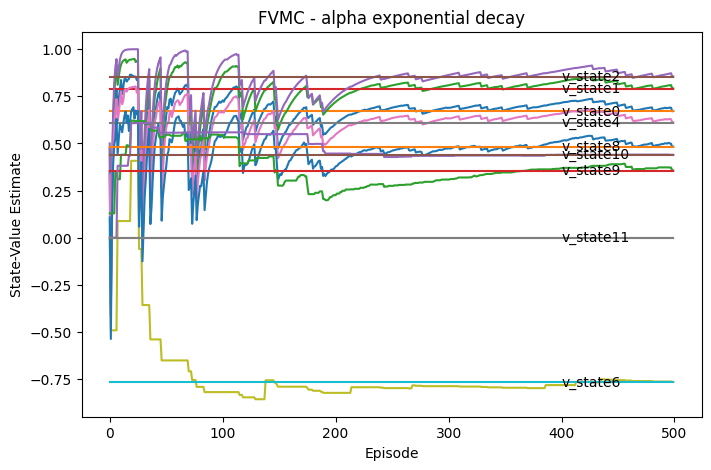

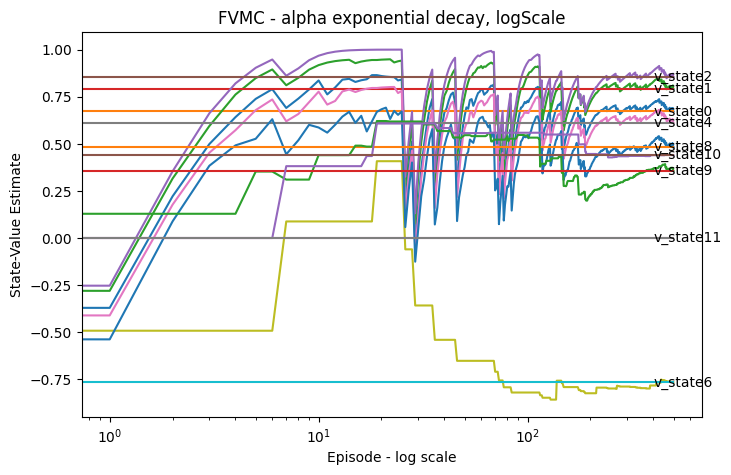

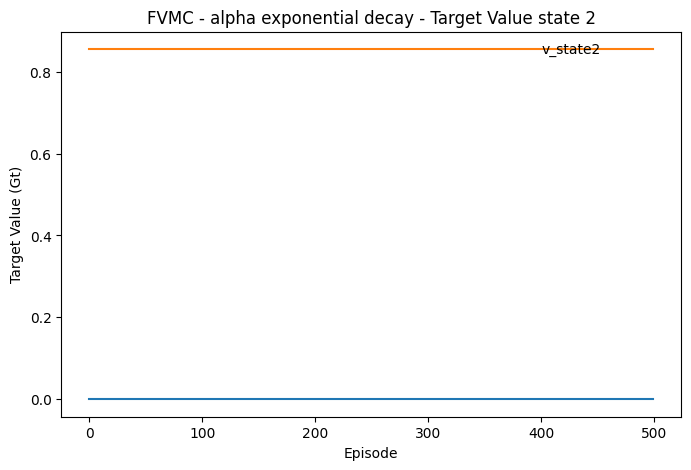

In [41]:
v, v_r, target_value = MonteCarloPrediction(env, optimized_policy, 0.99, alpha, 200, 500, True, chosen_nonTerminal_state) 
#assuming our env will stop before 200 steps for each episode

titles = ['FVMC - alpha exponential decay', 'FVMC - alpha exponential decay, logScale', 'FVMC - alpha exponential decay - Target Value state 2']
plot_results(v, v_r, target_value, total_episode, 2, titles)

# Subproblem 9, 15, 21

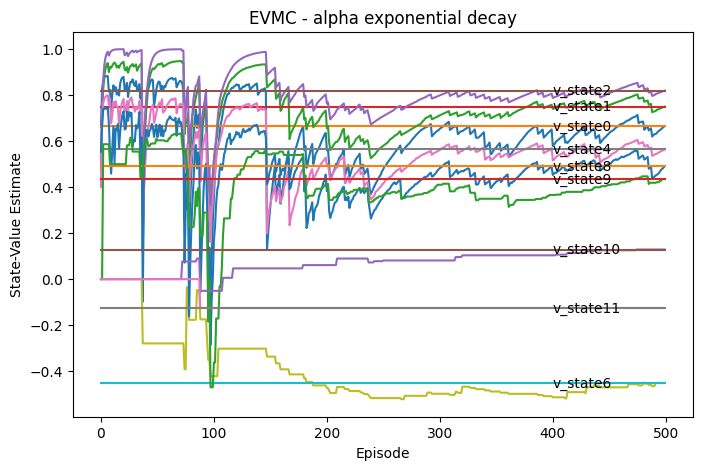

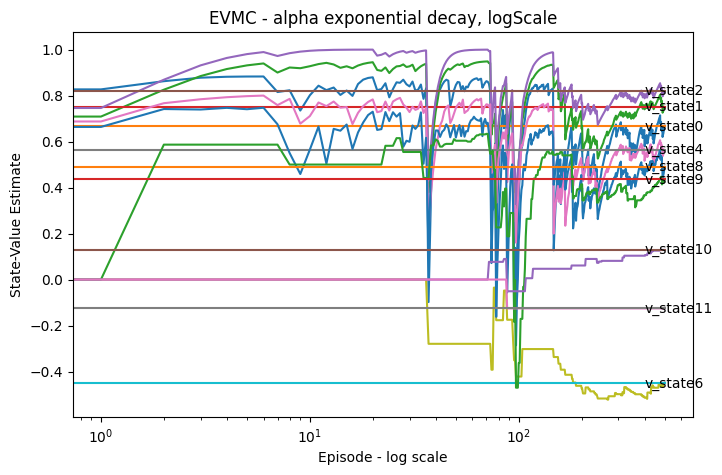

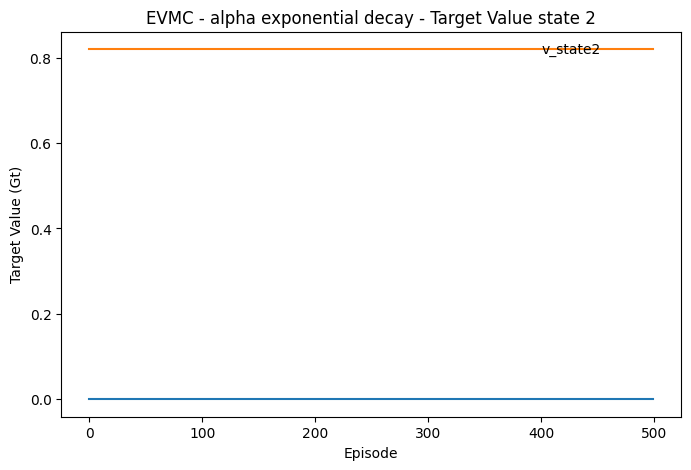

In [42]:
v, v_r, target_value = MonteCarloPrediction(env, optimized_policy, gamma, alpha, 200, 500, False, chosen_nonTerminal_state) 
#assuming our env will stop before 200 steps for each episode

titles = ['EVMC - alpha exponential decay', 'EVMC - alpha exponential decay, logScale', 'EVMC - alpha exponential decay - Target Value state 2']
plot_results(v, v_r, target_value, total_episode, 2, titles)

# Subproblem 10, 16, 22

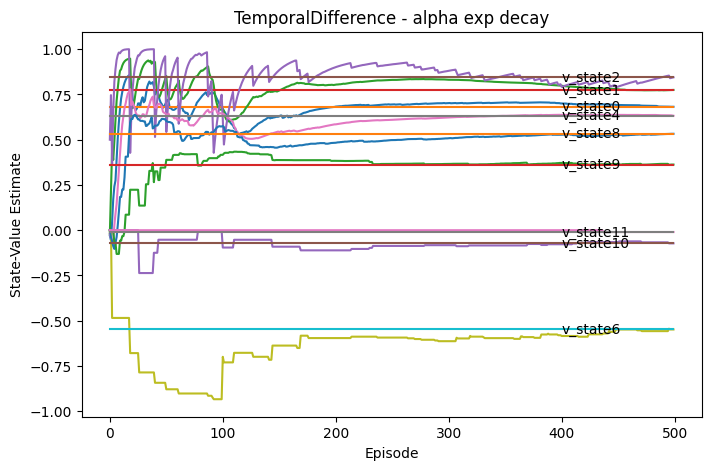

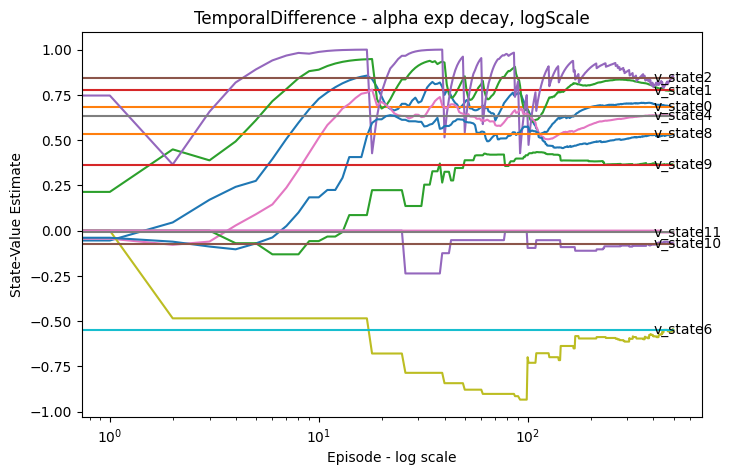

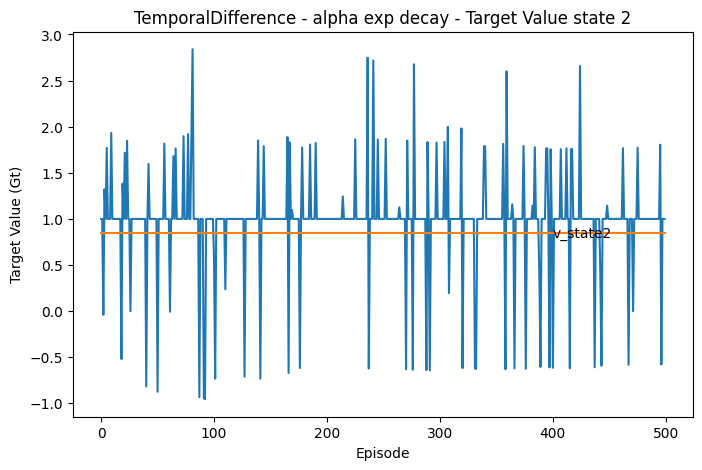

In [43]:
v, v_r, target_value = TemporalDifferencePrediction(env, optimized_policy, 0.99, alpha, 500, 2) #assuming our env will stop before 200 steps for each episode

titles = ['TemporalDifference - alpha exp decay', 'TemporalDifference - alpha exp decay, logScale', 'TemporalDifference - alpha exp decay - Target Value state 2']
plot_results(v, v_r, target_value, total_episode, 2, titles)